# **Neural style transfer**



## Introduction

Style transfer consists in generating an image
with the same "content" as a base image, but with the
"style" of a different picture (typically artistic).
This is achieved through the optimization of a loss function
that has 3 components: "style loss", "content loss",
and "total variation loss"

Refrence : [Neural style transfer](https://keras.io/examples/generative/neural_style_transfer/)

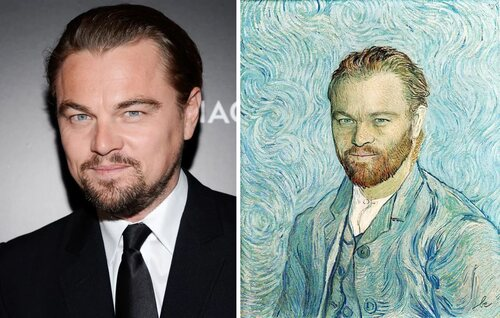

## Setup the libraries that help us for the model and extract 2 photos  from the internet using 'keras.utils.get_file' :
1. content image
2. style image


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
base_image_path = keras.utils.get_file("ro.jpg", "https://aast.edu/AboutAaSt01/contentplus/retreiveOnePIC.php?disp_unit=655&img=/rokaya.jpg")
style_reference_image_path = keras.utils.get_file(
    "van1.jpg", "https://www.biography.com/.image/ar_4:3%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cq_auto:good%2Cw_1200/MTY2NTIzMzc4MTI2MDM4MjM5/vincent_van_gogh_self_portrait_painting_musee_dorsay_via_wikimedia_commons_promojpg.jpg"
)
result_prefix = "paris_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 2e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


16384/11 [==============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

UnidentifiedImageError: ignored

## Show the content image and our style image


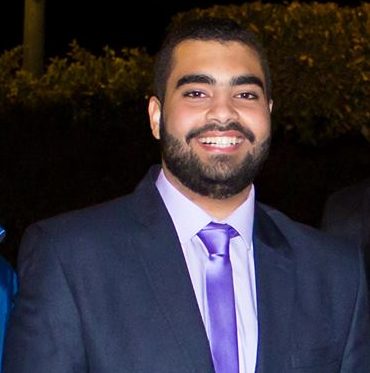

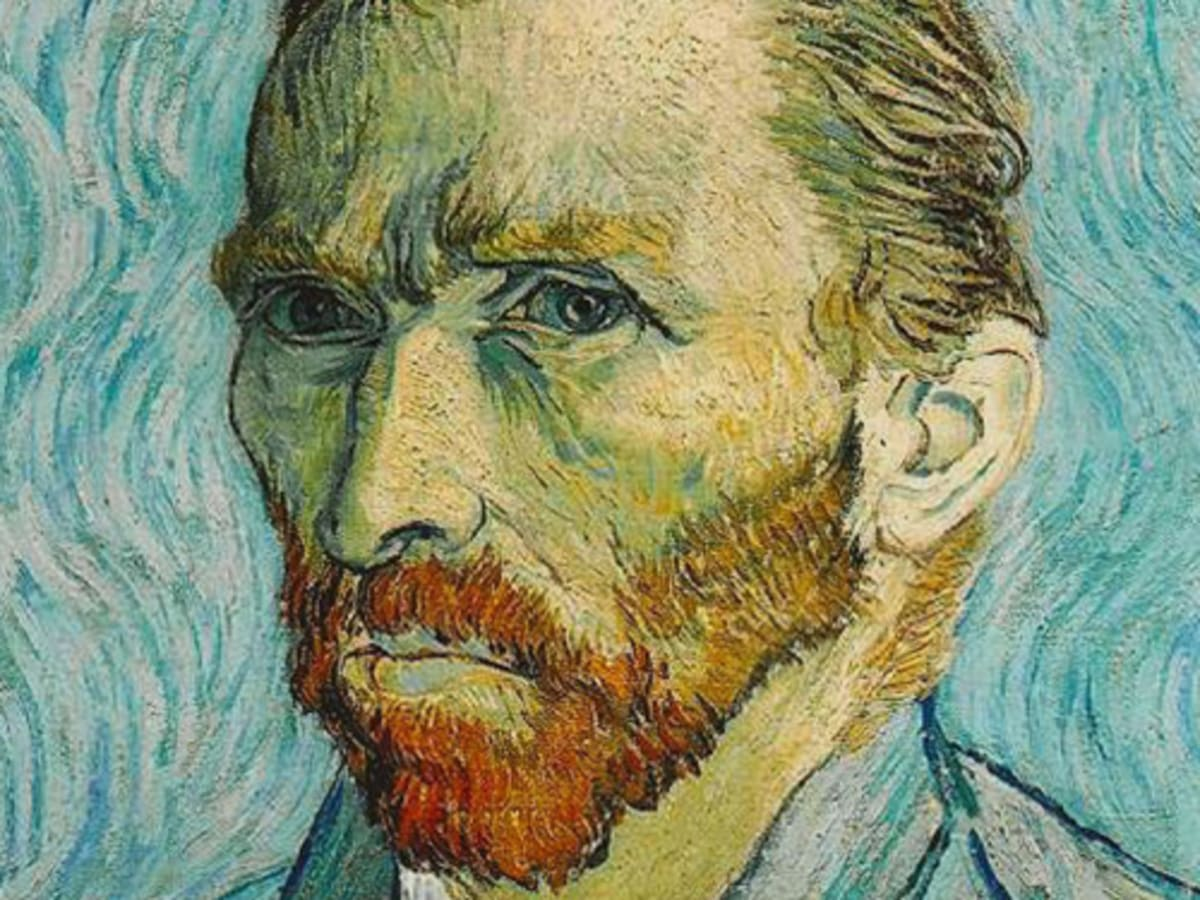

In [2]:
from IPython.display import Image, display
# cv2_imshow(base_image_path)
display(Image(base_image_path))
display(Image(style_reference_image_path))


## Image preprocessing :
1.  resize the image to a proprate size for the tensor
2. change the image to 1D in "expand_dims"
3. preprocess_input are convert from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
4. return tensor
## deprocessing utilities :
1. convert the tensor to image
2. convert the image from BGR to RGB


In [3]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x



## Compute the style transfer loss

First, we need to define 4 utility functions:

- `gram_matrix` (used to compute the style loss)

- The `style_loss` function, which keeps the generated image close to the local textures
of the style reference image
- The `content_loss` function, which keeps the high-level representation of the
generated image close to that of the content image
- The `total_variation_loss` function, a regularization loss which keeps the generated
image locally-coherent


### gram matrix 
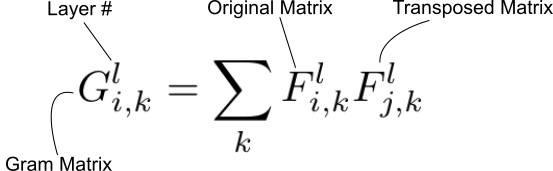

### content loss

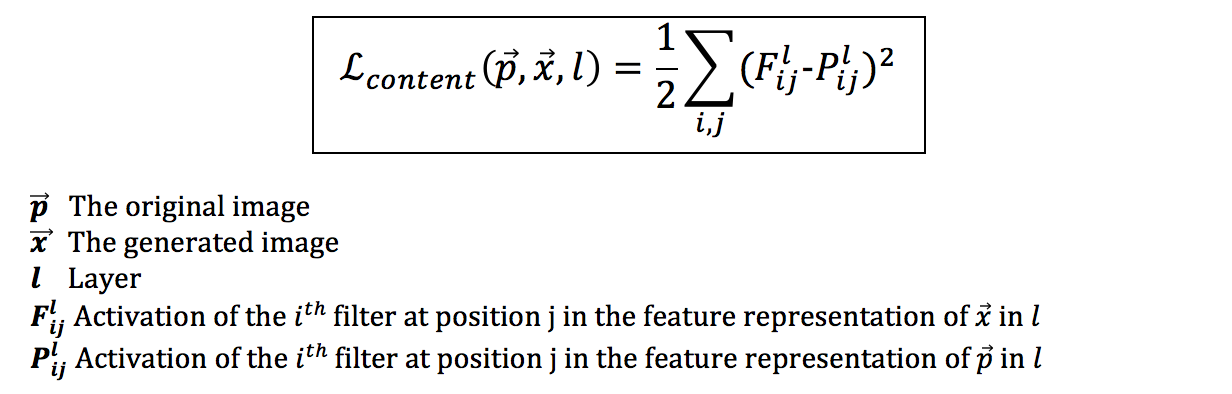

### style loss
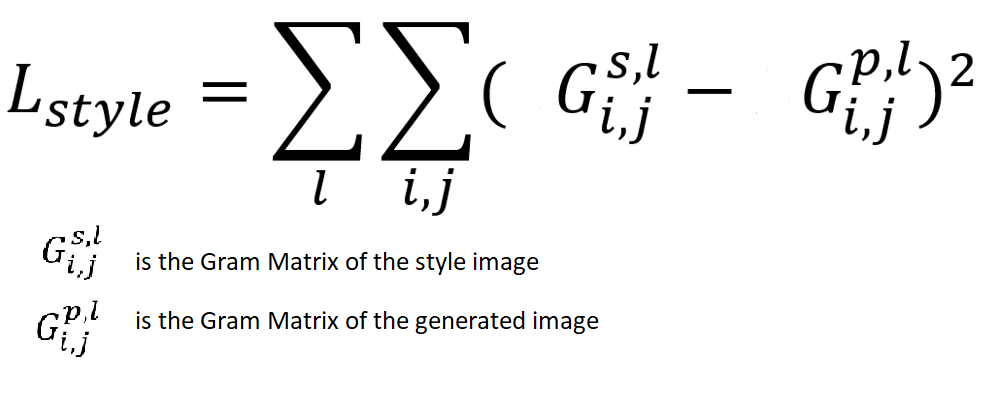

In [4]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))



Next, let's create a feature extraction model that retrieves the intermediate activations
of VGG19 (as a dict, by name).


In [5]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


80150528/80134624 [==============================] - 1s 0us/step


Finally, here's the code that computes the style transfer loss.
 1. CNN keeps learning a few features. The no. of channels in the output of a filter is equal to the no. of features learnt at that layer. that's why we used 5 layers in style 

In [6]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss



## Add a tf.function decorator to loss & gradient computation


In [7]:

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads



## The training loop

Repeatedly run vanilla gradient descent steps to minimize the loss, and save the
resulting image every 100 iterations.
1. SGD (grediant desent) : 
1. initial learing rate : learning rate that will start (higher learning rate more foucs on the higher feathers ex.the width of the tower
2. decay : number of step the model will take 
3. decay rate : each epoch decay step it will reduce = decay step / decay rate

2. iteration = epochs
We decay the learning rate by 0.96 every 100 steps.


In [8]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=150.0, decay_steps=100, decay_rate=0.75
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 6000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)
#19800

Iteration 100: loss=2027.64
Iteration 200: loss=1691.32
Iteration 300: loss=1580.05
Iteration 400: loss=1523.05
Iteration 500: loss=1488.89
Iteration 600: loss=1466.72
Iteration 700: loss=1451.63
Iteration 800: loss=1441.08
Iteration 900: loss=1433.53
Iteration 1000: loss=1428.07
Iteration 1100: loss=1424.07
Iteration 1200: loss=1421.13
Iteration 1300: loss=1418.95
Iteration 1400: loss=1417.33
Iteration 1500: loss=1416.13
Iteration 1600: loss=1415.23
Iteration 1700: loss=1414.56
Iteration 1800: loss=1414.06
Iteration 1900: loss=1413.68
Iteration 2000: loss=1413.40
Iteration 2100: loss=1413.19
Iteration 2200: loss=1413.03
Iteration 2300: loss=1412.92
Iteration 2400: loss=1412.83
Iteration 2500: loss=1412.76
Iteration 2600: loss=1412.71
Iteration 2700: loss=1412.67
Iteration 2800: loss=1412.65
Iteration 2900: loss=1412.63
Iteration 3000: loss=1412.61
Iteration 3100: loss=1412.60
Iteration 3200: loss=1412.60
Iteration 3300: loss=1412.59
Iteration 3400: loss=1412.59
Iteration 3500: loss=14

After 4000 iterations, you get the following result:


### dispaly the image

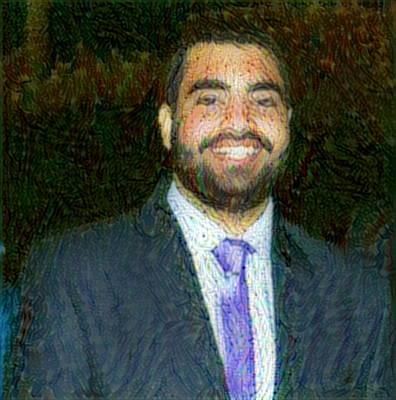

In [9]:
display(Image(result_prefix + "_at_iteration_6000.png"))
